In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request

In [ ]:
# [트레이닝 셋 불러오기]
# 0,3,6 데이터 200개씩
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/jaehosung/ml4se_codes/main/prev/sample-images_01.txt",
    "images.txt",
)
df_training_set = pd.read_csv("images.txt", sep=",", header=None)
    # 트레이닝 셋 할당, 이미지 1개는 1과 0으로 이루어진 784(28픽셀x28픽셀) 행렬
    # (size=(600,784))

print(df_training_set.iloc[0].values.reshape(28, 28))


In [ ]:

def fit_EM(df_training_set, iteration_num):

    # 베르누이 확률 분포
    def calc_bernoulli(x, mu):  # x (size = (784,)), mu (size = (784,))
        p = np.prod(mu[x == 1]) * np.prod(1 - mu[x == 0])
        return p

    # E(expectation) step
    # 각 이미지가 k 이미지 생성기를 통해서 얻어질 가능성 계산
    def calc_r_n_k(df_training_set, pi, mu):
        # r_n_k: 데이터가 k번째 이미지 생성기로부터 이미지가 얻어질 가능성
        r_n_k = np.empty(shape=(0, K))

        # r_n_k 계산하기. N개의 데이터에 대해서 차례대로 계산, x_n (size=(784,))
        for _, x_n in df_training_set.iterrows():
            r_i_k = np.array([])
            
            # r_i_k_denom(denominator) 계산: sigma(pi * P_mu_k)
            r_i_k_denom = 0.0
            for k in range(K):
                r_i_k_denom += pi[k] * calc_bernoulli(x_n, mu[k])
            
            for k in range(K):  # K개의 이미지 생성기에 대해서 차례대로 계산
                p_mu_k = calc_bernoulli(x_n, mu[k])  # p_u_k : p_u_k(x_n)
                # r_i_k_numer(numerator) 계산: pi * p_mu_k(x_n)     
                r_i_k_numer = pi[k] * p_mu_k

                # r_i_k = r_i_k_numer / r_i_k_denom
                r_i_k = np.append(r_i_k, r_i_k_numer / r_i_k_denom)
                    
            r_n_k = np.append(r_n_k, [r_i_k], axis = 0)
        return r_n_k

    # M(maximization) step
    # 새로운 이미지 생성기 mu와 이미지 생성기를 선택할 확률 pi 계산
    def calc_mu_pi(df_training_set, r_n_k, pi, K):
        mu_numer = np.zeros(shape = (K, 28 * 28))
        for k in range(K):  # K개의 이미지 생성기에 대해서 차례대로 계산
            mu_denom = r_n_k[:, k].sum()  # mu_denom = sigma_n(r_n_k) (dtype: float)
            
            # mu_numer(numerator) (size = (K, 284))
            for i, x_n in df_training_set.iterrows(): # N개의 데이터에 대해서 차례대로 계산
                mu_numer[k] += r_n_k[i][k] * x_n  # mu_k 분모: sigma_n(r_n_k * x_n)
            mu[k] = mu_numer[k] / mu_denom
                # mu_k = sigma_n(r_n_k * x_n) / sigma(r_n_k)
            
            # pi
            pi[k] = mu_denom / N  # pi_k = sigma(n_k) / N

        return mu, pi

    # mu, pi 초기값 설정
    pi = np.full(K, 1 / K)  # pi: K번째 이미지 생성기를 선택할 확률 (size=(K,))
    # mu = (np.random.rand(28 * 28 * K) * 0.5 + 0.25).reshape(K, 28 * 28)
    mu = (np.random.rand(28 * 28 * K) * 0.5 + 0.25).reshape(K, 28 * 28)
        # TODO 왜 0.25를 더하는지에 대한 이유 찾아보기 혹은 빼보기
        # mu: K개의 이미지 생성기 (size=(K,784))

    mu_hist = pd.DataFrame([], columns=["mu"])
    mu_hist = mu_hist.append({"mu":mu.copy()}, ignore_index=True)

    for iter_num in range(iteration_num):
        print("iter_num %d" % iter_num)

        r_n_k = calc_r_n_k(df_training_set, pi, mu)
            # 각 이미지가 k 이미지 생성기를 통해서 얻어질 가능성 계산
        mu, pi = calc_mu_pi(df_training_set, r_n_k, pi, K)
            # 새로운 이미지 생성기 mu와 이미지 생성기를 선택할 확률 pi 계산
        mu_hist = mu_hist.append({"mu":mu.copy()}, ignore_index=True)

    return mu, r_n_k, mu_hist

In [ ]:
def draw_generator(axs_generators, K, iter_num, mu):
    for k in range(K):
        axs_generators[k, iter_num].set_xticks([])
        axs_generators[k, iter_num].set_yticks([])
        axs_generators[k, iter_num].imshow(mu[k].reshape(28, 28), cmap=plt.cm.gray_r)

# 분류 결과의 시각화 함수
def draw_result(mu, r_argmax, axs):
    for c in range(K):
        # 이미지 생성기 시각화
        axs[c, 0].set_xticks([])
        axs[c, 0].set_yticks([])
        axs[c, 0].imshow(mu[c].reshape(28, 28), cmap=plt.cm.gray_r)

        # K번째 이미지 생성기에 속하는 데이터
        i = 1
        for j in range(len(r_argmax)):
            if r_argmax[j] == c:
                axs[c, i].set_xticks([])
                axs[c, i].set_yticks([])
                axs[c, i].imshow(
                    df_training_set.iloc[j].values.reshape(28, 28),
                    cmap=plt.cm.gray_r
                )
                i += 1
                if i > 6:
                    break
# 분류된 데이터 시각화
def draw_classified_result(generator_num):
    col_len = 20
    
    cond = df_r_n_k.idxmax(axis=1) == generator_num
    data_num = df_r_n_k[cond].index.size
    row_len = int(data_num/ col_len) + 1

    fig_classified_result, axs_classified_result = plt.subplots(
        row_len, col_len, figsize=(col_len, row_len)
    )

    i = 0
    df_r_n_k.sort_values(generator_num, axis=0,ascending=False)
    df_r_n_k_iter = df_r_n_k[cond].copy()
    print("number of data classified by generator %d: %d"%(generator_num,data_num))
    for idx, line in df_r_n_k_iter.iterrows():
        if i < col_len * row_len:
            row = int(i / col_len)
            col = i % col_len
            axs_classified_result[row][col].imshow(
                df_training_set.iloc[idx].values.reshape(28, 28),
                cmap=plt.cm.gray_r
            )
            i = i + 1
    for row in range(row_len):
        for col in range(col_len):
            axs_classified_result[row][col].set_xticks([])
            axs_classified_result[row][col].set_yticks([])
    fig_classified_result.tight_layout()
    
def find_classified_data_idx(df_r_n_k, k):
    cond = df_r_n_k["arg_max"] == k
    #sort해서 넘기기
    return df_r_n_k[cond].index

def draw_data_by_idx(df_r_n_k, k):
    idx_list = find_classified_data_idx(df_r_n_k, k)
    col_len = 20
    data_num = idx_list.size
    row_len = int(data_num/ col_len) + 1

    fig_classified_result, axs_classified_result = plt.subplots(
        row_len, col_len, figsize=(col_len, row_len)
    )
    i = 0
    print("number of data classified by generator %d: %d"%(k,data_num))
    for idx in idx_list:
        if i < col_len * row_len:
            row = int(i / col_len)
            col = i % col_len
            axs_classified_result[row][col].imshow(
                df_training_set.iloc[idx].values.reshape(28, 28),
                cmap=plt.cm.gray_r
            )
            i = i + 1

    for row in range(row_len):
        for col in range(col_len):
            axs_classified_result[row][col].set_xticks([])
            axs_classified_result[row][col].set_yticks([])
    fig_classified_result.tight_layout()

In [ ]:
np.random.seed(0)

# 파라미터 설정
N = len(df_training_set)  # 데이터 개수 (600)
K = 3  # 생성기 개수
iteration_num = 10  # 생성기 생성 반복 횟수
mu, r_n_k, mu_hist = fit_EM(df_training_set, iteration_num)

In [ ]:
# 생성기의 변화 시각화 / axs_generators (size=(K, iteration_num+1))
fig_generators, axs_generators = plt.subplots(
    K, iteration_num + 1,
    figsize=(iteration_num+1,K)
)

for idx, data in mu_hist.iterrows():
    draw_generator(axs_generators, K, idx, data["mu"])

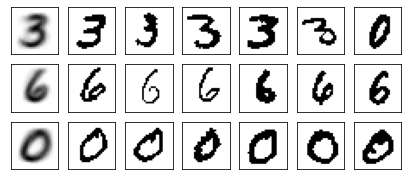

In [15]:
# 분류 결과 표시
fig_result, axs_result = plt.subplots(K, 7, figsize = (7,K))
r_argmax = list(r_n_k.argmax(axis=1))  # 가장 높은 확률로 소속될 생성기의 인덱스
draw_result(mu, r_argmax, axs_result)

number of data classified by generator 0: 210
number of data classified by generator 1: 200
number of data classified by generator 2: 190


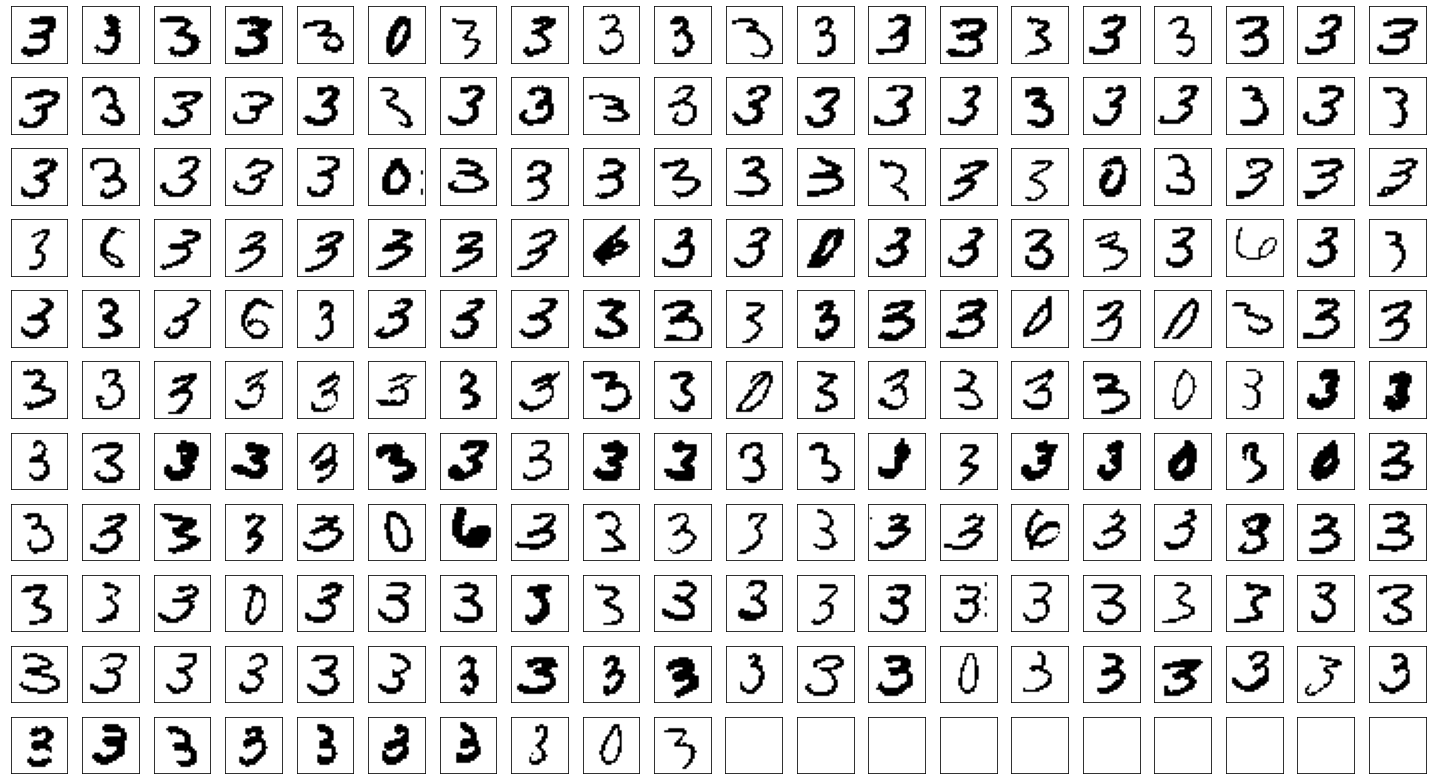

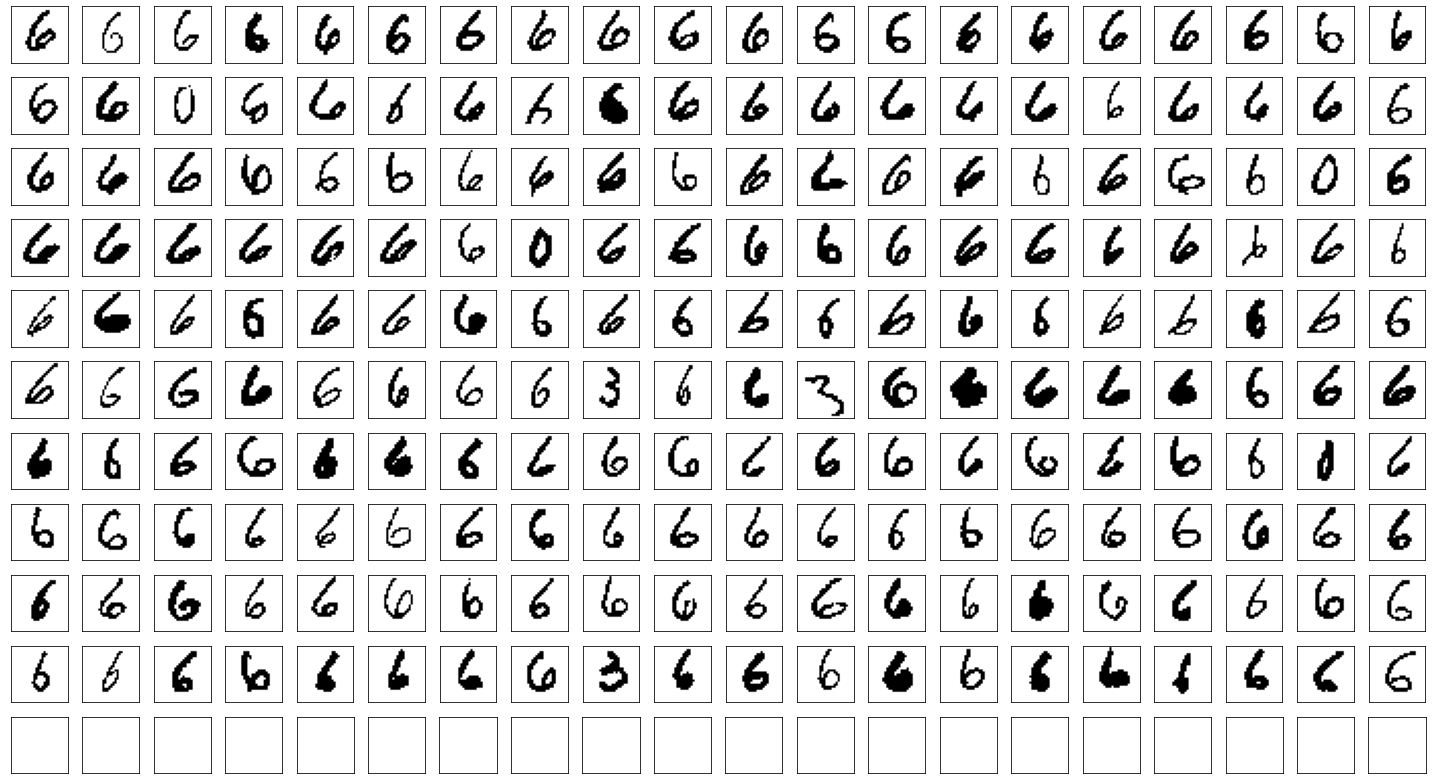

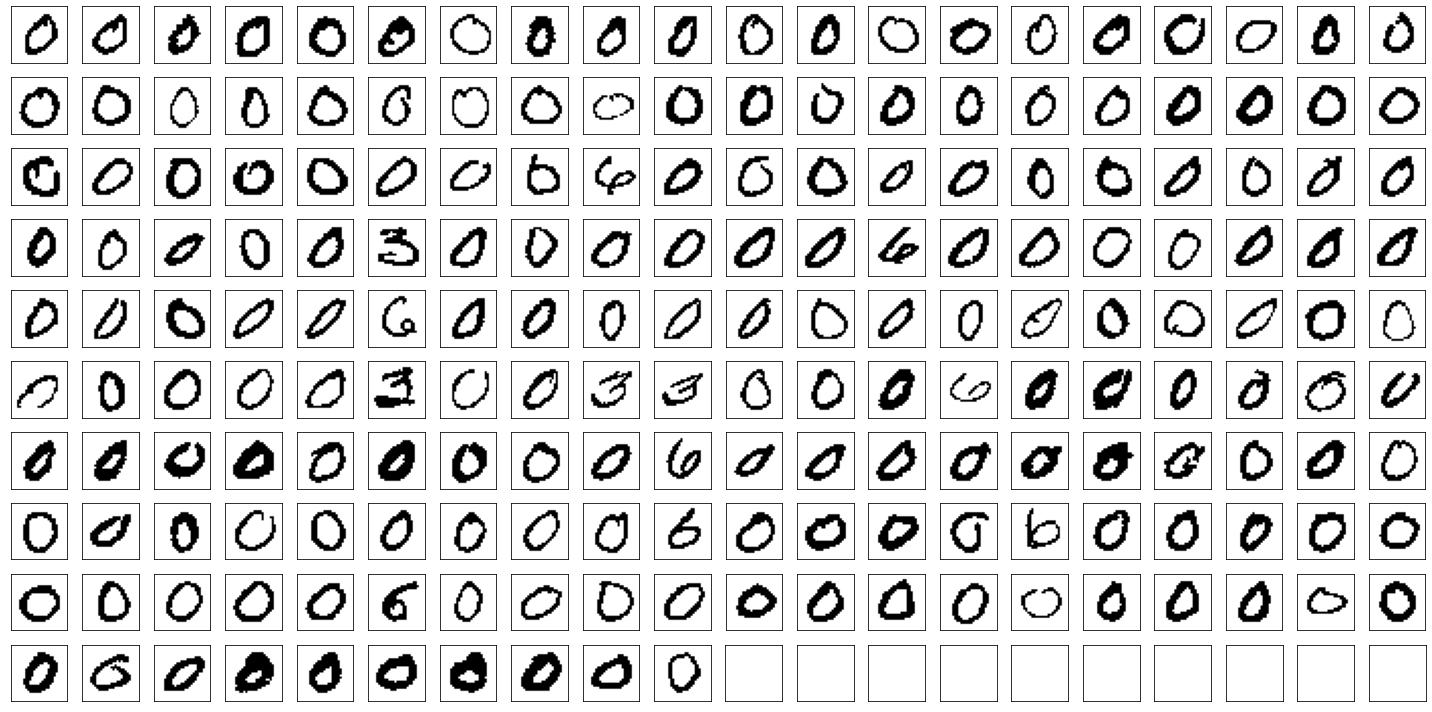

In [16]:
# 분류 결과 표시
df_r_n_k = pd.DataFrame(r_n_k)
r_argmax = list(r_n_k.argmax(axis=1))
  # 가장 높은 확률로 소속될 생성기의 인덱스
df_r_n_k["arg_max"] = r_argmax

for k in range(K):
    draw_data_by_idx(df_r_n_k, k)